# Part 4: Sentiment Analysis

### Create Sentiment Analysis Scores for each Individual Review

TextBlob polarity and subjectivity, and Vader compound score.

In [2]:
!pip install textblob

In [3]:
!pip install matplotlib

In [4]:
!pip install seaborn

In [5]:
# Imports and Helper functions

from datetime import datetime
import time
import requests
import pickle
from pathlib import Path
import re
import random

import pandas as pd

In [6]:
# imports for SA
from textblob import TextBlob
from textblob import Word

## Prep the Data

In [7]:
## load the cleaned reviews
review_df = pd.read_csv(f'data/review_tokenized.csv')
review_df['recommendationid'] = review_df['recommendationid'].astype("str")
# review_df.head()
print(review_df.shape)

(48662, 3)


In [8]:
raw_review_df = pd.read_csv(f'data/raw_reviews.csv')[['recommendationid', 'review_text']]
raw_review_df['recommendationid'] = raw_review_df['recommendationid'].astype("str")
raw_review_df.head()
# print(raw_review_df.shape)

,recommendationid,review_text
0,212664845,Addictive. Stressful. Time waster.
1,212664820,fuak arc\r\n
2,212664759,W
3,212664729,awesome game!
4,212664705,If the Steam comments section is like every ot...


In [9]:
## we actually want the raw text, so we can tokenize it (and not lemmatize it)
## but we've filtered out some results due to text length, so we join the raw_reviews to the cleaned_reviews
## so we only do SA on the reviews we've included in the corpus

review_token_df = pd.merge(review_df, raw_review_df, on="recommendationid")
review_token_df.head()

,recommendationid,Appname,review_cleaned,review_text
0,212664845,ARC Raiders,addictive stressful time waster,Addictive. Stressful. Time waster.
1,212664705,ARC Raiders,steam comment section like every comment secti...,If the Steam comments section is like every ot...
2,212664692,ARC Raiders,like gathering sneak around arc pvp part peopl...,I like the gathering and sneaking around the A...
3,212664560,ARC Raiders,well make game every time hop experience somet...,"Very well made game, every time I hop on I exp..."
4,212664471,ARC Raiders,think would sweaty honestly somehow stop playi...,I thought this would be too sweaty for me. Hon...


In [10]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import word_tokenize

In [11]:
# tokenize each review
review_token_df['review_tokens'] = review_token_df['review_text'].apply(wordpunct_tokenize)
review_token_df['review_tokens']

0            [Addictive, ., Stressful, ., Time, waster, .]
1        [If, the, Steam, comments, section, is, like, ...
2        [I, like, the, gathering, and, sneaking, aroun...
3        [Very, well, made, game, ,, every, time, I, ho...
4        [I, thought, this, would, be, too, sweaty, for...
                               ...                        
48657                       [We, have, Hades, at, home, :]
48658    [Unfortunately, can, not, recommend, the, game...
48659    [if, you, enjoy, soulstone, survivors, or, had...
48660    [Great, game, overall, !, I, really, enjoy, th...
48661    [The, game, is, pretty, good, for, some, of, t...
Name: review_tokens, Length: 48662, dtype: object

In [12]:
# create a text column with tagged tokens
review_token_df['review_string'] = review_token_df['review_tokens'].apply (lambda row: ' '.join(str(x) for x in row))
# check the final text
review_token_df.head()

,recommendationid,Appname,review_cleaned,review_text,review_tokens,review_string
0,212664845,ARC Raiders,addictive stressful time waster,Addictive. Stressful. Time waster.,"[Addictive, ., Stressful, ., Time, waster, .]",Addictive . Stressful . Time waster .
1,212664705,ARC Raiders,steam comment section like every comment secti...,If the Steam comments section is like every ot...,"[If, the, Steam, comments, section, is, like, ...",If the Steam comments section is like every ot...
2,212664692,ARC Raiders,like gathering sneak around arc pvp part peopl...,I like the gathering and sneaking around the A...,"[I, like, the, gathering, and, sneaking, aroun...",I like the gathering and sneaking around the A...
3,212664560,ARC Raiders,well make game every time hop experience somet...,"Very well made game, every time I hop on I exp...","[Very, well, made, game, ,, every, time, I, ho...","Very well made game , every time I hop on I ex..."
4,212664471,ARC Raiders,think would sweaty honestly somehow stop playi...,I thought this would be too sweaty for me. Hon...,"[I, thought, this, would, be, too, sweaty, for...",I thought this would be too sweaty for me . Ho...


##### Add the polarity and subjectivity measures from TextBlob

In [13]:
# calculate polarity
review_token_df['polarity'] = review_token_df['review_string'].apply(
(lambda row: TextBlob (row).sentiment[0]))

# calculate subjectivity
review_token_df['subjectivity'] = review_token_df['review_string'].apply(
(lambda row: TextBlob (row).sentiment[1])
)

review_token_df.head()

## I can see small differences in polarity and subjectivity, but overall tokenizing isn't drastically changing sentiment analysis results

,recommendationid,Appname,review_cleaned,review_text,review_tokens,review_string,polarity,subjectivity
0,212664845,ARC Raiders,addictive stressful time waster,Addictive. Stressful. Time waster.,"[Addictive, ., Stressful, ., Time, waster, .]",Addictive . Stressful . Time waster .,0.000000,0.900000
1,212664705,ARC Raiders,steam comment section like every comment secti...,If the Steam comments section is like every ot...,"[If, the, Steam, comments, section, is, like, ...",If the Steam comments section is like every ot...,0.030422,0.493232
2,212664692,ARC Raiders,like gathering sneak around arc pvp part peopl...,I like the gathering and sneaking around the A...,"[I, like, the, gathering, and, sneaking, aroun...",I like the gathering and sneaking around the A...,-0.275000,0.250000
3,212664560,ARC Raiders,well make game every time hop experience somet...,"Very well made game, every time I hop on I exp...","[Very, well, made, game, ,, every, time, I, ho...","Very well made game , every time I hop on I ex...",-0.021212,0.384848
4,212664471,ARC Raiders,think would sweaty honestly somehow stop playi...,I thought this would be too sweaty for me. Hon...,"[I, thought, this, would, be, too, sweaty, for...",I thought this would be too sweaty for me . Ho...,0.252083,0.510417


### Add the compound score from NLTK

In [14]:
## imports for SA with NLTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/joh11678/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Calculate NLTK compound score tokenized
review_token_df['NLTK_Compound'] = review_token_df['review_string'].apply(
(lambda row: sia.polarity_scores(row)['compound'])
)

review_token_df.head()

## I tried with both the raw text and the tokenized text. Im going to use the tokenized results because I know they aren't getting tripped up by the \t characters

,recommendationid,Appname,review_cleaned,review_text,review_tokens,review_string,polarity,subjectivity,NLTK_Compound
0,212664845,ARC Raiders,addictive stressful time waster,Addictive. Stressful. Time waster.,"[Addictive, ., Stressful, ., Time, waster, .]",Addictive . Stressful . Time waster .,0.000000,0.900000,-0.5106
1,212664705,ARC Raiders,steam comment section like every comment secti...,If the Steam comments section is like every ot...,"[If, the, Steam, comments, section, is, like, ...",If the Steam comments section is like every ot...,0.030422,0.493232,-0.8888
2,212664692,ARC Raiders,like gathering sneak around arc pvp part peopl...,I like the gathering and sneaking around the A...,"[I, like, the, gathering, and, sneaking, aroun...",I like the gathering and sneaking around the A...,-0.275000,0.250000,-0.2498
3,212664560,ARC Raiders,well make game every time hop experience somet...,"Very well made game, every time I hop on I exp...","[Very, well, made, game, ,, every, time, I, ho...","Very well made game , every time I hop on I ex...",-0.021212,0.384848,0.3384
4,212664471,ARC Raiders,think would sweaty honestly somehow stop playi...,I thought this would be too sweaty for me. Hon...,"[I, thought, this, would, be, too, sweaty, for...",I thought this would be too sweaty for me . Ho...,0.252083,0.510417,0.4404


### Save output and display

In [16]:
## write sa results
review_token_df[['recommendationid', 'Appname', 'polarity', 'subjectivity', 'NLTK_Compound']].to_csv(f'data/review_sa.csv', index=False)

In [17]:
## load sa results
sa_df = pd.read_csv(f'data/review_sa.csv')
sa_df.head()

,recommendationid,Appname,polarity,subjectivity,NLTK_Compound
0,212664845,ARC Raiders,0.000000,0.900000,-0.5106
1,212664705,ARC Raiders,0.030422,0.493232,-0.8888
2,212664692,ARC Raiders,-0.275000,0.250000,-0.2498
3,212664560,ARC Raiders,-0.021212,0.384848,0.3384
4,212664471,ARC Raiders,0.252083,0.510417,0.4404


In [18]:
aggregate_functions = {}

for column in sa_df.columns[2:]:
      aggregate_functions[column] = 'mean' # For all the embedding columns, aggregate them by averaging

len(aggregate_functions)

3

In [19]:
## perform the aggregation
dsa_df = (sa_df
          .groupby(['Appname'])
          .agg(
              aggregate_functions
              )
)

In [20]:
y_var = pd.read_csv(f'data/y_variable.csv')
y_var.head()

,App ID,long_game,App Title
0,251570,1,7 Days to Die
1,1099410,1,A Total War Saga: TROY
2,1808500,1,ARC Raiders
3,2399830,1,ARK: Survival Ascended
4,427410,1,Abiotic Factor


In [21]:
vis_df = pd.merge(dsa_df, y_var, left_on='Appname', right_on='App Title')
vis_df.head()

,polarity,subjectivity,NLTK_Compound,App ID,long_game,App Title
0,0.112722,0.461096,0.499505,251570,1,7 Days to Die
1,0.068671,0.511913,0.233699,1099410,1,A Total War Saga: TROY
2,0.076805,0.465599,0.277117,1808500,1,ARC Raiders
3,0.056796,0.465828,0.348239,2399830,1,ARK: Survival Ascended
4,0.141545,0.476734,0.563143,427410,1,Abiotic Factor


In [22]:
vis_df[
    vis_df['long_game'].apply(lambda x: x == 1)
    ]

,polarity,subjectivity,NLTK_Compound,App ID,long_game,App Title
0,0.112722,0.461096,0.499505,251570,1,7 Days to Die
1,0.068671,0.511913,0.233699,1099410,1,A Total War Saga: TROY
2,0.076805,0.465599,0.277117,1808500,1,ARC Raiders
3,0.056796,0.465828,0.348239,2399830,1,ARK: Survival Ascended
4,0.141545,0.476734,0.563143,427410,1,Abiotic Factor
...,...,...,...,...,...,...
240,0.107065,0.425767,0.434751,552500,1,Warhammer: Vermintide 2
241,0.034936,0.517176,0.201743,1407200,1,World of Tanks
242,0.142971,0.426956,0.402333,552990,1,World of Warships
243,0.058489,0.453122,0.244306,638970,1,Yakuza 0


In [23]:
vis_df[
    vis_df['long_game'].apply(lambda x: x == 1)
    ][['polarity', 'subjectivity', 'NLTK_Compound']].describe()

,polarity,subjectivity,NLTK_Compound
count,125.000000,125.000000,125.000000
mean,0.098386,0.467049,0.384534
std,0.068176,0.039906,0.168353
min,-0.170073,0.200000,-0.056688
25%,0.058489,0.452645,0.244306
50%,0.101464,0.469785,0.395216
75%,0.141545,0.489405,0.506201
max,0.300000,0.574082,0.728845


In [24]:
vis_df[
    vis_df['long_game'].apply(lambda x: x == 0)
    ][['polarity', 'subjectivity', 'NLTK_Compound']].describe()

,polarity,subjectivity,NLTK_Compound
count,122.000000,122.000000,122.000000
mean,0.127301,0.475891,0.458724
std,0.061705,0.031401,0.150718
min,-0.167284,0.399319,-0.421500
25%,0.100273,0.456557,0.384810
50%,0.131565,0.475290,0.476980
75%,0.160481,0.499143,0.554028
max,0.306207,0.571457,0.692809


In [31]:
vis_df['long game'] = vis_df['long_game'].apply(lambda x: "<40 Hours" if x==0 else ">40 Hours")

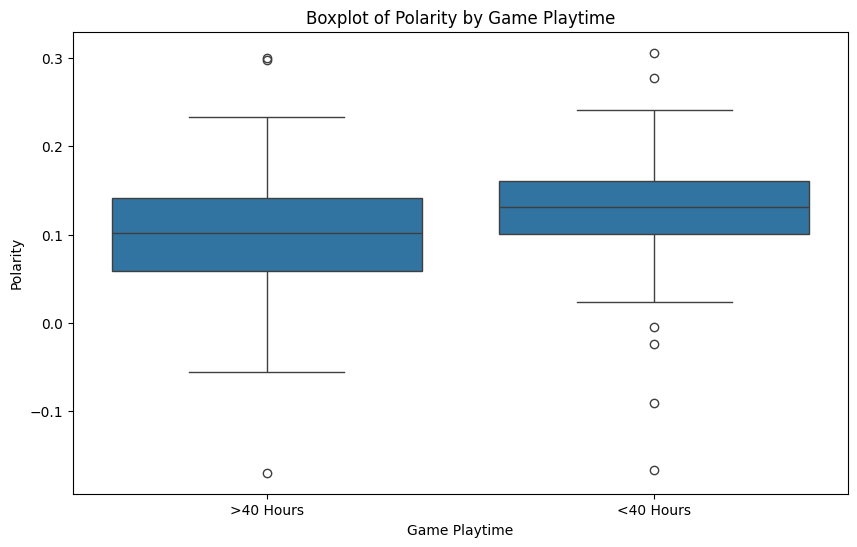

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='long game', y='polarity', data=vis_df)


# Adding titles and labels
plt.title('Boxplot of Polarity by Game Playtime')
plt.xlabel('Game Playtime')
plt.ylabel('Polarity')

# Show the plot
plt.show()

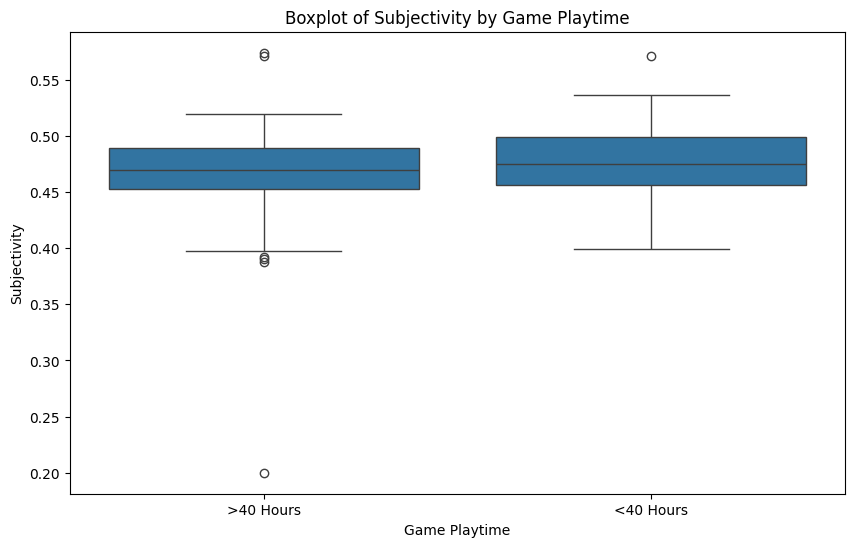

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='long game', y='subjectivity', data=vis_df)

# Adding titles and labels
plt.title('Boxplot of Subjectivity by Game Playtime')
plt.xlabel('Game Playtime')
plt.ylabel('Subjectivity')

# Show the plot
plt.show()

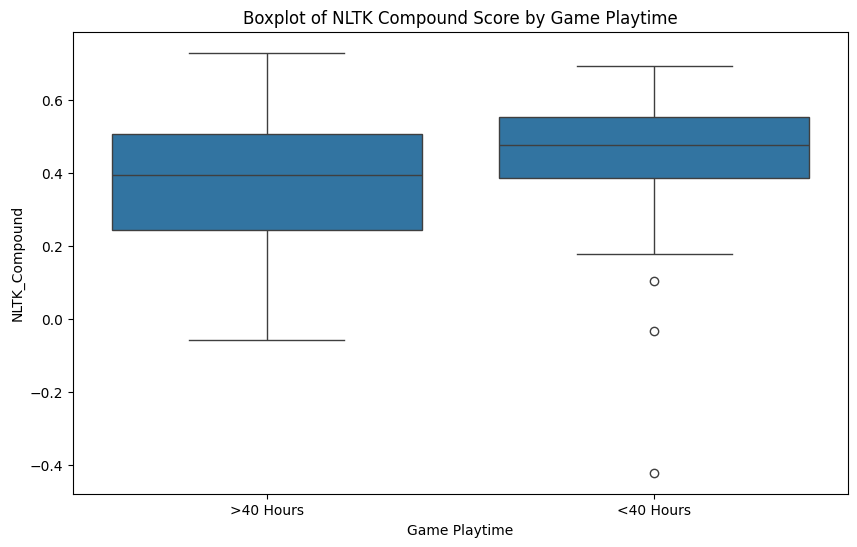

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='long game', y='NLTK_Compound', data=vis_df)

# Adding titles and labels
plt.title('Boxplot of NLTK Compound Score by Game Playtime')
plt.xlabel('Game Playtime')
plt.ylabel('NLTK_Compound')

# Show the plot
plt.show()

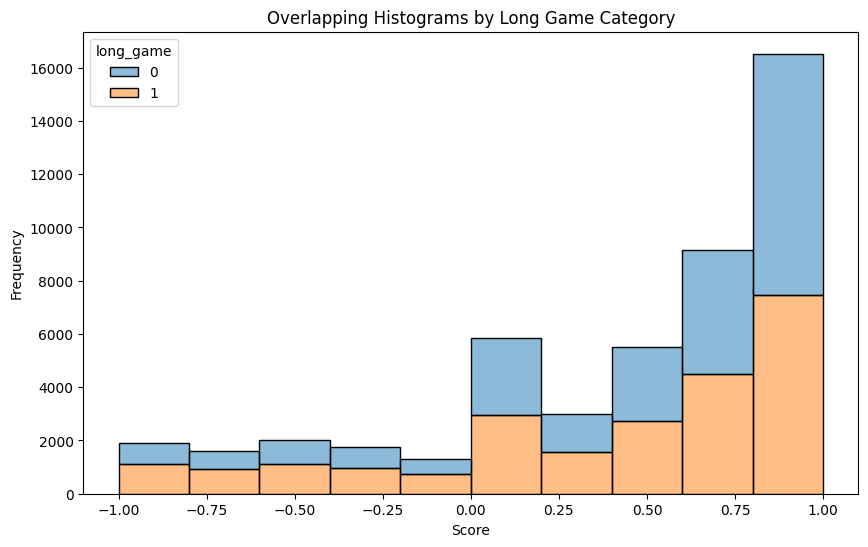

In [84]:
plt.figure(figsize=(10, 6))
sns.histplot(data=vis_df, x='NLTK_Compound', hue='long_game', bins=10, alpha=0.5, multiple='stack')
plt.title('Overlapping Histograms by Long Game Category')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

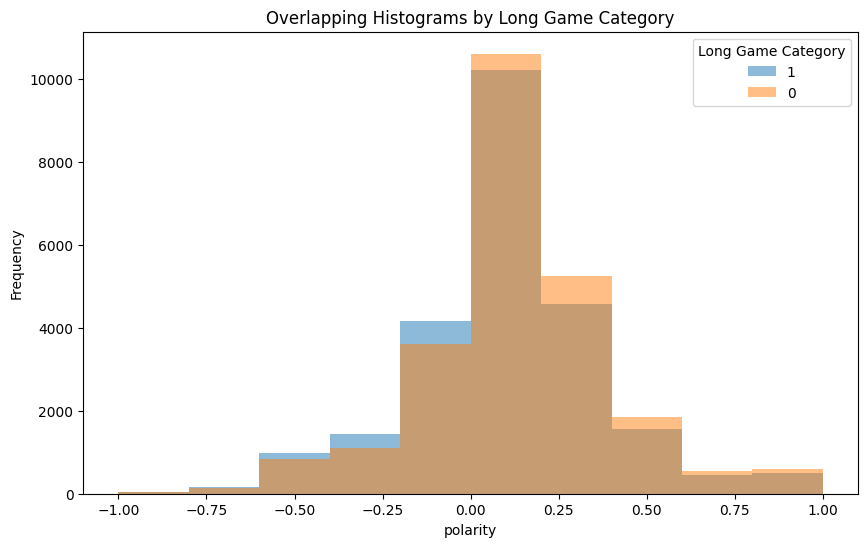

In [86]:
plt.figure(figsize=(10, 6))

# Plot histograms for each category
for category in vis_df['long_game'].unique():
    subset = vis_df[vis_df['long_game'] == category]
    plt.hist(subset['polarity'], bins=10, alpha=0.5, label=category)

plt.title('Overlapping Histograms by Long Game Category')
plt.xlabel('polarity')
plt.ylabel('Frequency')
plt.legend(title='Long Game Category')
plt.show()